<a href="https://colab.research.google.com/github/DerManjuel/MIR/blob/Manuel/NLP_Pipeline_different_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
    <h1 align="center">Excercise 03 - Medical Information Retrieval 2023</h1>
  </div>
  <br />

Before you start with this exercise:

In the last weeks exercise, we went through the NLP-steps data-exploration, data cleaning and tokenization. In the end of this exercise we want to test a simple machine learning model, which takes your preprocessed texts as input. Therefore, we suggest that, before you start, you copy your code from data cleaning inside this notebook and continue with the following tasks. **A tokenizer is not needed in this exercise**.

In [1]:
! git clone https://github.com/DerManjuel/MIR

fatal: destination path 'MIR' already exists and is not an empty directory.


In [2]:
# From last week:

import pandas as pd
import re

# 1. Read in the data

df = pd.read_csv('Data/mtsamples_clean.csv')
df.head()

,medical_specialty,transcription
0,Allergy / Immunology,"SUBJECTIVE:, This 23-year-old white female pr..."
1,Bariatrics,"PAST MEDICAL HISTORY:, He has difficulty climb..."
2,Bariatrics,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ..."
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...


In [3]:
# 2. Clean the data (lowercase, removing all punctuation, etc.)

# remove empty rows
df = df.dropna(subset=['transcription'])

# lowercase all
df['transcription'] = df['transcription'].apply(lambda s: s.lower())

# remove punctuation
df['transcription'] = df['transcription'].apply(lambda s: re.sub(r'[^\w\s]', ' ', s))

df.head()

,medical_specialty,transcription
0,Allergy / Immunology,subjective this 23 year old white female pr...
1,Bariatrics,past medical history he has difficulty climb...
2,Bariatrics,history of present illness i have seen abc ...
3,Cardiovascular / Pulmonary,2 d m mode 1 left atrial enlargement wit...
4,Cardiovascular / Pulmonary,1 the left ventricular cavity size and wall ...


### Stop Word Analysis

Stop words are words that are commonly used in a language, but do not add any value to the meaning of a sentence. Examples of stop words in English include "the", "and", "a", "an", "in", etc. In this task, we will remove stop words from the preprocessed text data in order to improve the quality of our classification results.

Please perform the following steps:

* Use the nltk library to obtain a list of stop words in English.
* Remove the stop words from the preprocessed text data in the dataset.
* Compare the results of the classification with and without stop word removal.

In [4]:
from collections import Counter
from tabulate import tabulate

def unique_words_counter(df):
    # utils function to count unique words in our corpus
    word_counts = Counter()
    for s in df['transcription']:
        word_counts.update(s.split())
    return word_counts

# 3. Stop word removal

# lets look at the most common words in our corpus

word_counts = unique_words_counter(df)

# print most common words
print(tabulate(word_counts.most_common(16), headers=['Word', 'Count']))


# those are mostly stop words, lets remove them 
# but first, lets count all words in the corpus and see how many unique words there are before stop word removal

print(f'There are {len(word_counts)} unique words in our corpus before stop word removal')


# lets remove stop words

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = stopwords.words('english')

df['transcription'] = df['transcription'].apply(lambda s: ' '.join([word for word in s.split() if word not in stop_words]))

print(f'There are {len(unique_words_counter(df))} unique words in our corpus after stop word removal')

Word       Count
-------  -------
the       149888
and        82779
was        71765
of         59205
to         50632
a          43031
with       35815
in         32808
is         26378
patient    24208
no         17874
she        17593
for        17049
he         15544
were       15535
on         14694
There are 22498 unique words in our corpus before stop word removal


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/manuel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


There are 22361 unique words in our corpus after stop word removal


## NLP Pipeline - Part 2 <a class="anchor" id="first"></a>

This week, we further focus on two common preprocessing steps in the NLP pipeline: stemming/lemmatization and stop word analysis.

### Stemming/Lemmatization
Stemming and lemmatization are techniques used to reduce inflectional and derivational forms of words to their base or root form, in order to simplify the analysis of text data. In this task, we will use the nltk library to perform stemming and lemmatization on the preprocessed text data.

Please perform the following steps:

* Choose a stemmer from the nltk library and apply it to the tokenized text in the dataset.
* Choose a lemmatizer from the nltk library and apply it to the tokenized text in the dataset.
* Compare the results of the stemming and lemmatization techniques on the dataset.

Lets stem the words using the Porter Stemmer

In [5]:
# 3. Stemming/Lemmatization

print(f'There are {len(unique_words_counter(df))} unique words in our corpus before stemming')

from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

df['transcription'] = df['transcription'].apply(lambda s: ' '.join([stemmer.stem(word) for word in s.split()]))

# lets count all words in the corpus and see how many unique words there are after stemming

word_counts = Counter()

for s in df['transcription']:
    word_counts.update(s.split())

print(f'There are {len(word_counts)} unique words in the corpus after stemming')

There are 22361 unique words in our corpus before stemming
There are 15994 unique words in the corpus after stemming


Now lets look at the most common words in our corpus


In [6]:
print(tabulate(word_counts.most_common(16), headers=['Word', 'Count']))

Word        Count
--------  -------
patient     24275
right       11587
left        11258
2           10136
1            9842
histori      9514
use          9129
place        8369
procedur     8100
normal       7680
3            7228
0            7172
well         6643
5            6614
pain         6297
4            6263


As you can see there are some number in the dataset, it might be useful to remove them as well, however, they can also contain some medical relevant information, so lets keep them for now.

For testing purposes, we want to adjust the preprocessing pipeline in a modular way, that we can see the impact of different preprocessing strategies on the model performance
Therefore, we will sklearn's pipeline class and put every preprocessing step into a separate class

In [7]:
# data-cleaner class

from sklearn.base import BaseEstimator, TransformerMixin
from nltk.stem import WordNetLemmatizer
import nltk
from tqdm import tqdm

class DataCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        
        print('Lowercasing')
        for i in tqdm(range(len(X)), total=len(X)):
            X[i] = X[i].lower()

        
        print('Removing punctuation')
        for i in tqdm(range(len(X)), total=len(X)):
            X[i] = re.sub(r'[^\w\s]', ' ', X[i])
        
        return X
    
# stop-word-remover class

class StopWordRemover(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        print('Removing stop words')
        for i in tqdm(range(len(X)), total=len(X)):
            X[i] = ' '.join([word for word in X[i].split() if word not in stop_words])
        
        return X
    
# stemmer class

class Stemmer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # stem words
        print('Stemming')
        for i in tqdm(range(len(X)), total=len(X)):
            X[i] = ' '.join([stemmer.stem(word) for word in X[i].split()])
        
        return X
    
# lemmatizer class

nltk.download('wordnet')
nltk.download('omw-1.4')

class Lemmatizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # lemmatize words
        print('Lemmatizing')
        lemmatizer = WordNetLemmatizer()
        for i in tqdm(range(len(X)), total=len(X)):
            X[i] = ' '.join([lemmatizer.lemmatize(word) for word in X[i].split()])
        
        return X

[nltk_data] Downloading package wordnet to /Users/manuel/nltk_data...
[nltk_data] Downloading package omw-1.4 to /Users/manuel/nltk_data...


### Test your preprocessing steps!

It is crucial to test the effectiveness of our preprocessing techniques on the accuracy of a machine learning classifier, as the quality of the data fed into the model can have a significant impact on the model's performance. If the input data is noisy, contains irrelevant information, or is not properly transformed, the accuracy of the resulting model will suffer. Therefore, it is important to **evaluate the impact of our preprocessing techniques on the classification task.**

In this exercise, we provide you with a simple baseline model for text classification using scikit-learn. Now, it's time to test the effectiveness of your techniques you learned so-far on the classification accuracy.

To do this, we recommend that you first select a subset of the dataset and preprocess it using the techniques learned in the previous sections. Then, train a machine learning classifier on the preprocessed data using the given pipeline. Finally, evaluate the accuracy of the classifier on the preprocessed data and compare it with the accuracy of the same classifier trained on the raw data.

The following train-function takes the pandas dataframe as input and trains a naive-bayes classifier on it.

Note, that the following train-function takes a pandas dataframe as input. **You should keep the column-names for notes ("transcription") and classes ("medical_specialty").**

In [24]:
from tkinter import E
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from nltk.tokenize import WhitespaceTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer as CountVectorizerSklearn
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier

sns.set(rc={'axes.facecolor':'lightblue', 'figure.facecolor':'white'})


def train(df, net_arch='naive_bayes', savename="plot.png"):
    X_train, X_test, y_train, y_test = train_test_split(df['transcription'].values, df['medical_specialty'].values, test_size=0.2, random_state=42)

    # Define the text classification pipeline
    if net_arch == 'SVC':
      print('SVC')
      text_clf = Pipeline([
          ('vect', CountVectorizerSklearn(lowercase=False, tokenizer=WhitespaceTokenizer().tokenize)), # use the custom tokenizer
          ('clf', SVC(kernel='linear'))
      ])
    elif net_arch == 'naive_bayes':
      print('Naive Bayes')
      text_clf = Pipeline([
          ('vect', CountVectorizerSklearn(lowercase=False, tokenizer=WhitespaceTokenizer().tokenize)), # use the custom tokenizer
          ('clf', MultinomialNB())
      ])
    elif net_arch == 'mlp':
      print('MLP')
      text_clf = Pipeline([
          ('vect', CountVectorizerSklearn(lowercase=False, tokenizer=WhitespaceTokenizer().tokenize)), # use the custom tokenizer
          ('clf', MLPClassifier())
      ])
    elif net_arch == 'gauss':
      print('Gauss')
      text_clf = Pipeline([
          ('vect', CountVectorizerSklearn(lowercase=False, tokenizer=WhitespaceTokenizer().tokenize)), # use the custom tokenizer
          ('clf', GaussianProcessClassifier())
      ])
    elif net_arch == 'knn':
      print('KNN')
      text_clf = Pipeline([
          ('vect', CountVectorizerSklearn(lowercase=False, tokenizer=WhitespaceTokenizer().tokenize)), # use the custom tokenizer
          ('clf', KNeighborsClassifier())
      ])
    else:
      print('using naive_bayes as default network architecture')
      text_clf = Pipeline([
          ('vect', CountVectorizerSklearn(lowercase=False, tokenizer=WhitespaceTokenizer().tokenize)), # use the custom tokenizer
          ('clf', MultinomialNB())
      ])

    # Train the pipeline on the preprocessed data
    text_clf.fit(X_train, y_train)

    predicted = text_clf.predict(X_test)

    # Classification report
    report = classification_report(y_test, predicted, output_dict=True)

    # change figsize
    plt.figure(figsize=(20, 10))
    report_df = pd.DataFrame(report).iloc[:-1, :].T

    sns.heatmap(pd.DataFrame(report_df), annot=True)

    plt.savefig(savename, bbox_inches='tight', transparent=False)



Lets apply the preprocessing pipeline to our data to test it on our training script.

In [12]:
# helper function

def apply_preprocessing(pipeline=None):
    df = pd.read_csv('Data/mtsamples_clean.csv')
    df = df.dropna(subset=['transcription'])

    if pipeline is not None:
        X = df['transcription'].values
        X = pipeline.transform(X)
        df['transcription'] = X

    return df

No preprocessing
using naive_bayes as default network architecture


/Users/manuel/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/manuel/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/manuel/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/manuel/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

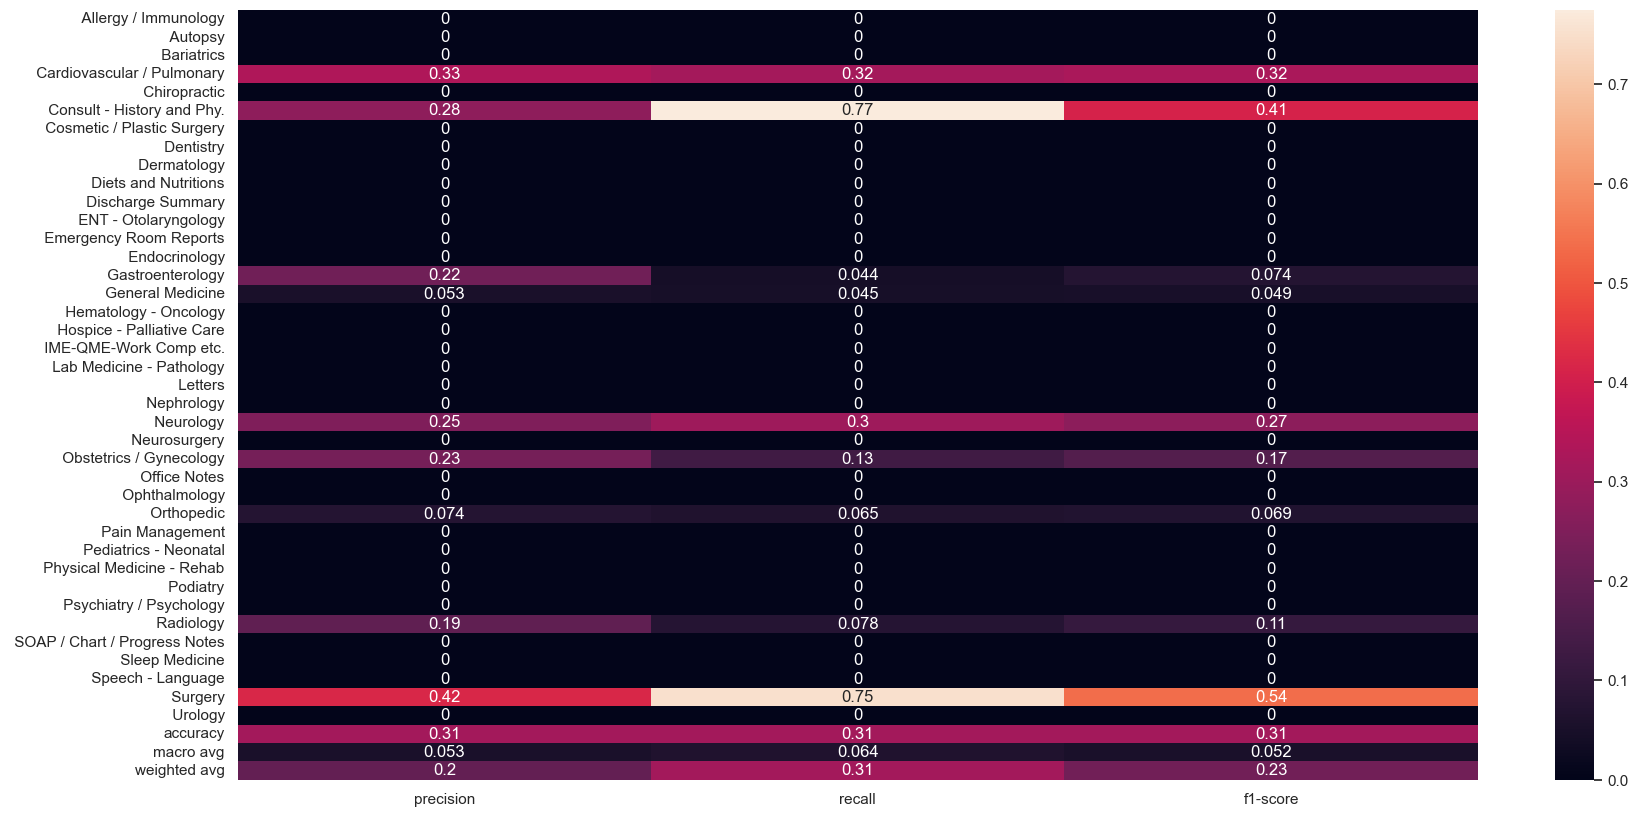

In [20]:
# 1. no preprocessing

print('No preprocessing')
df = apply_preprocessing(pipeline=None)

train(df, 'gauss', savename='no_preprocessing_gauss')

No preprocessing
MLP


/Users/manuel/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/manuel/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/manuel/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/manuel/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to cont

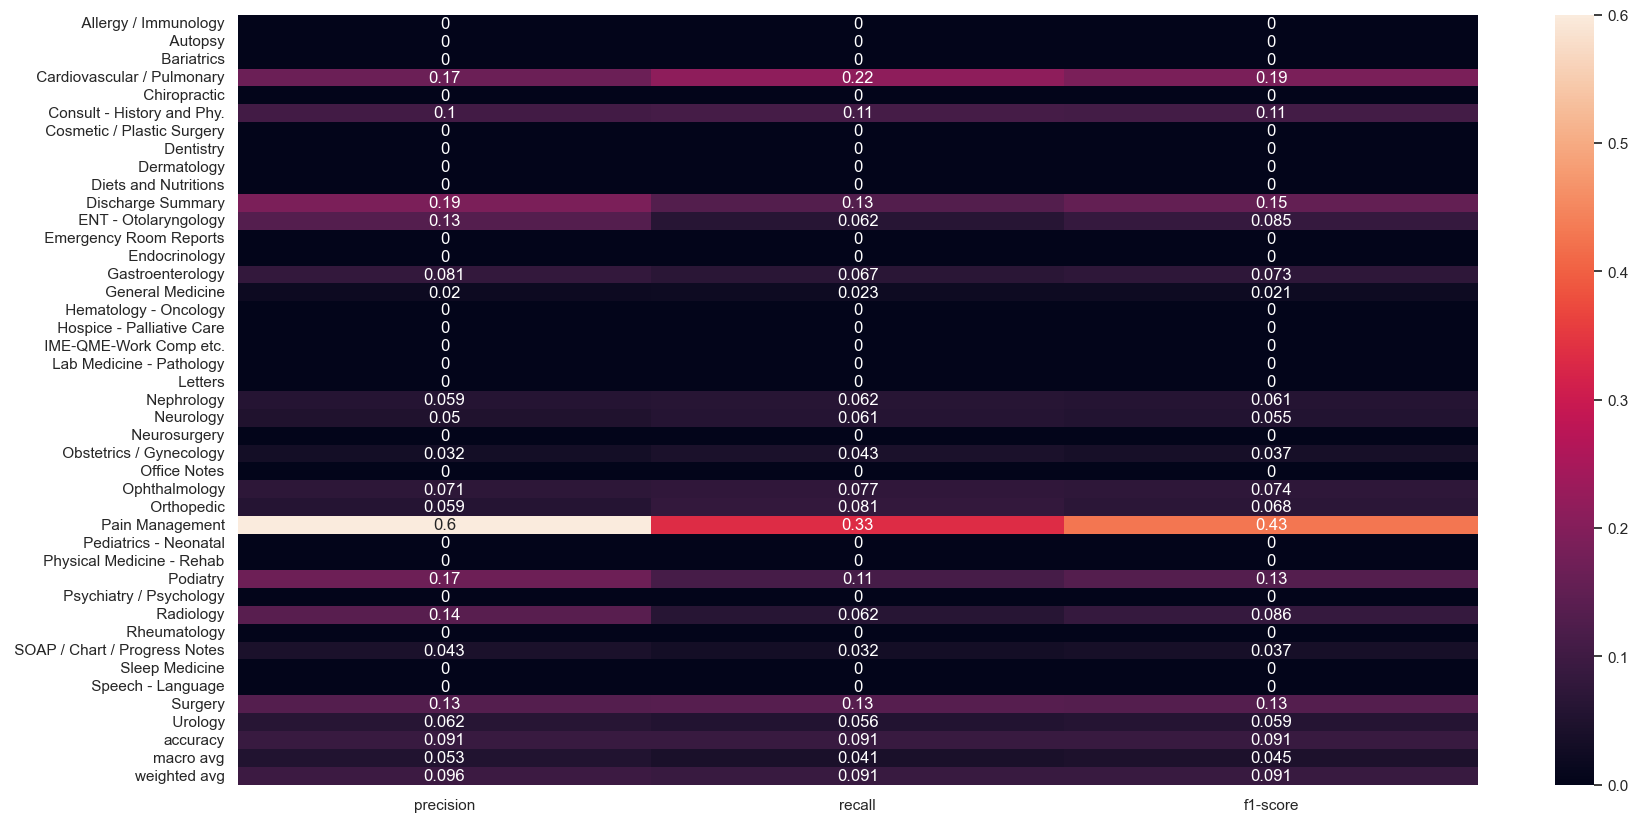

In [13]:
# 1. no preprocessing

print('No preprocessing')
df = apply_preprocessing(pipeline=None)

train(df, 'mlp', savename='no_preprocessing_mlp')

No preprocessing
SVC


/Users/manuel/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/manuel/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/manuel/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/manuel/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precisi

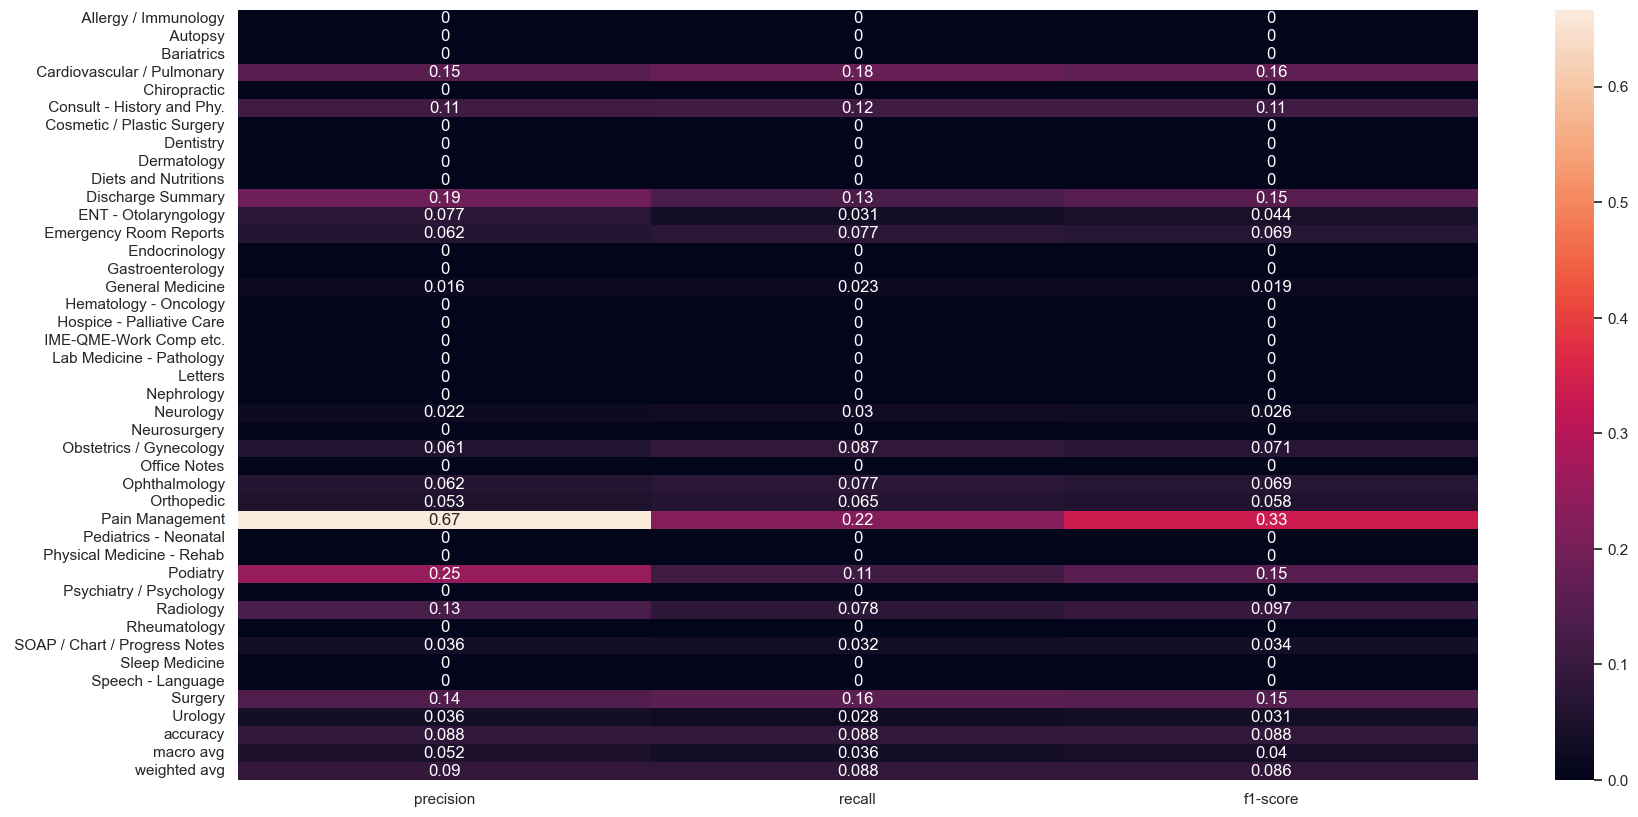

In [17]:
# 1. no preprocessing

print('No preprocessing')
df = apply_preprocessing(pipeline=None)

train(df, 'SVC', savename='no_preprocessing_svc')

No preprocessing
Naive Bayes


/Users/manuel/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/manuel/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/manuel/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/manuel/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

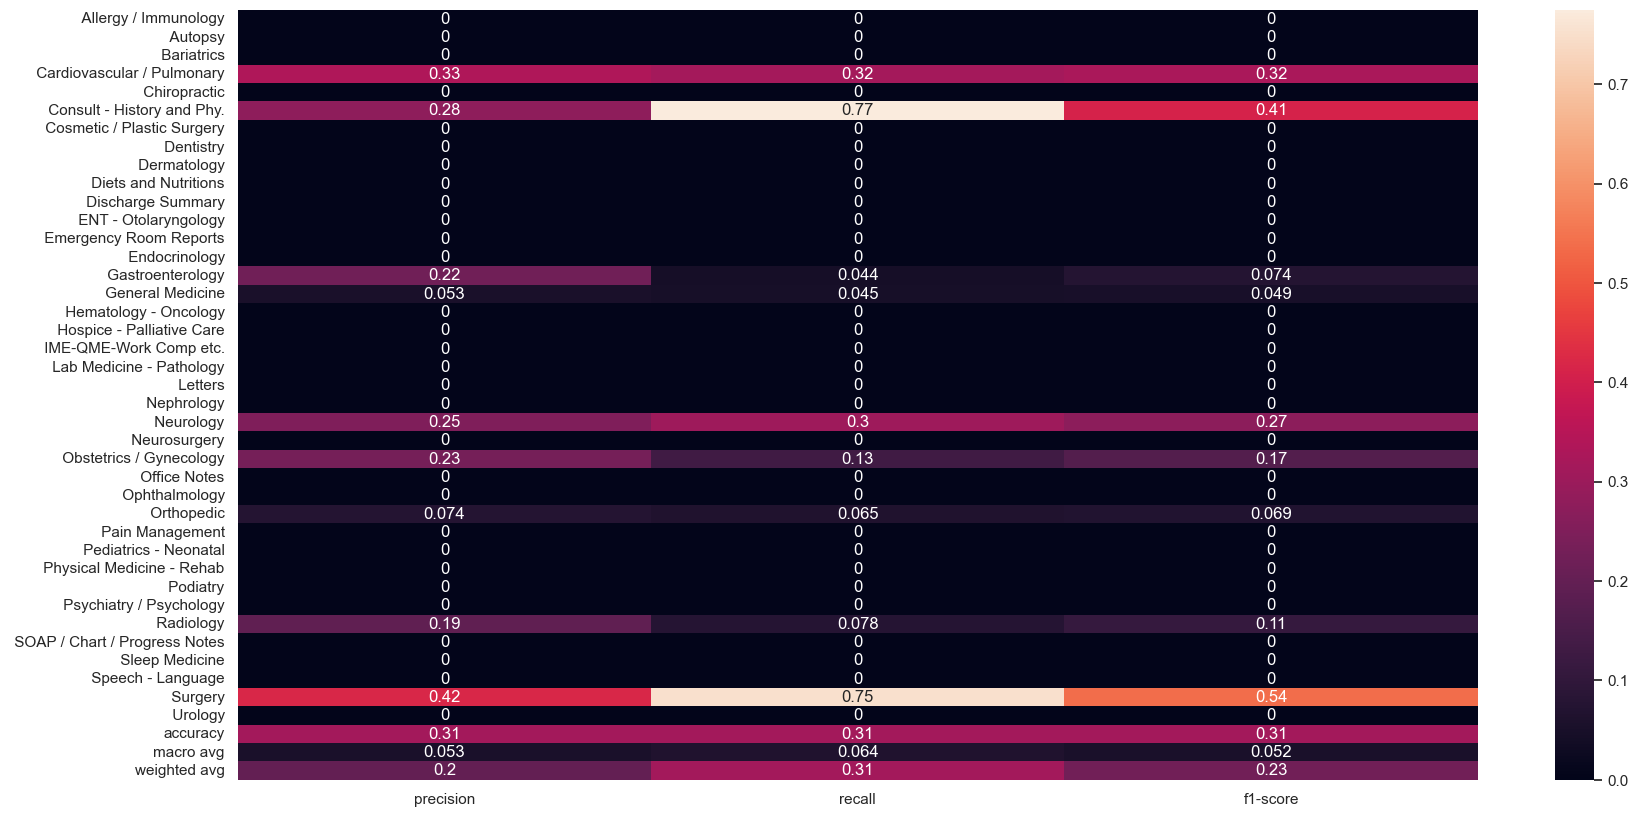

In [15]:
# 1. no preprocessing

print('No preprocessing')
df = apply_preprocessing(pipeline=None)

train(df, savename='no_preprocessing_bayes')

Only with removing punctuation
Lowercasing


100%|██████████| 4966/4966 [00:00<00:00, 250389.65it/s]


Removing punctuation


100%|██████████| 4966/4966 [00:00<00:00, 12313.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


using naive_bayes as default network architecture


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


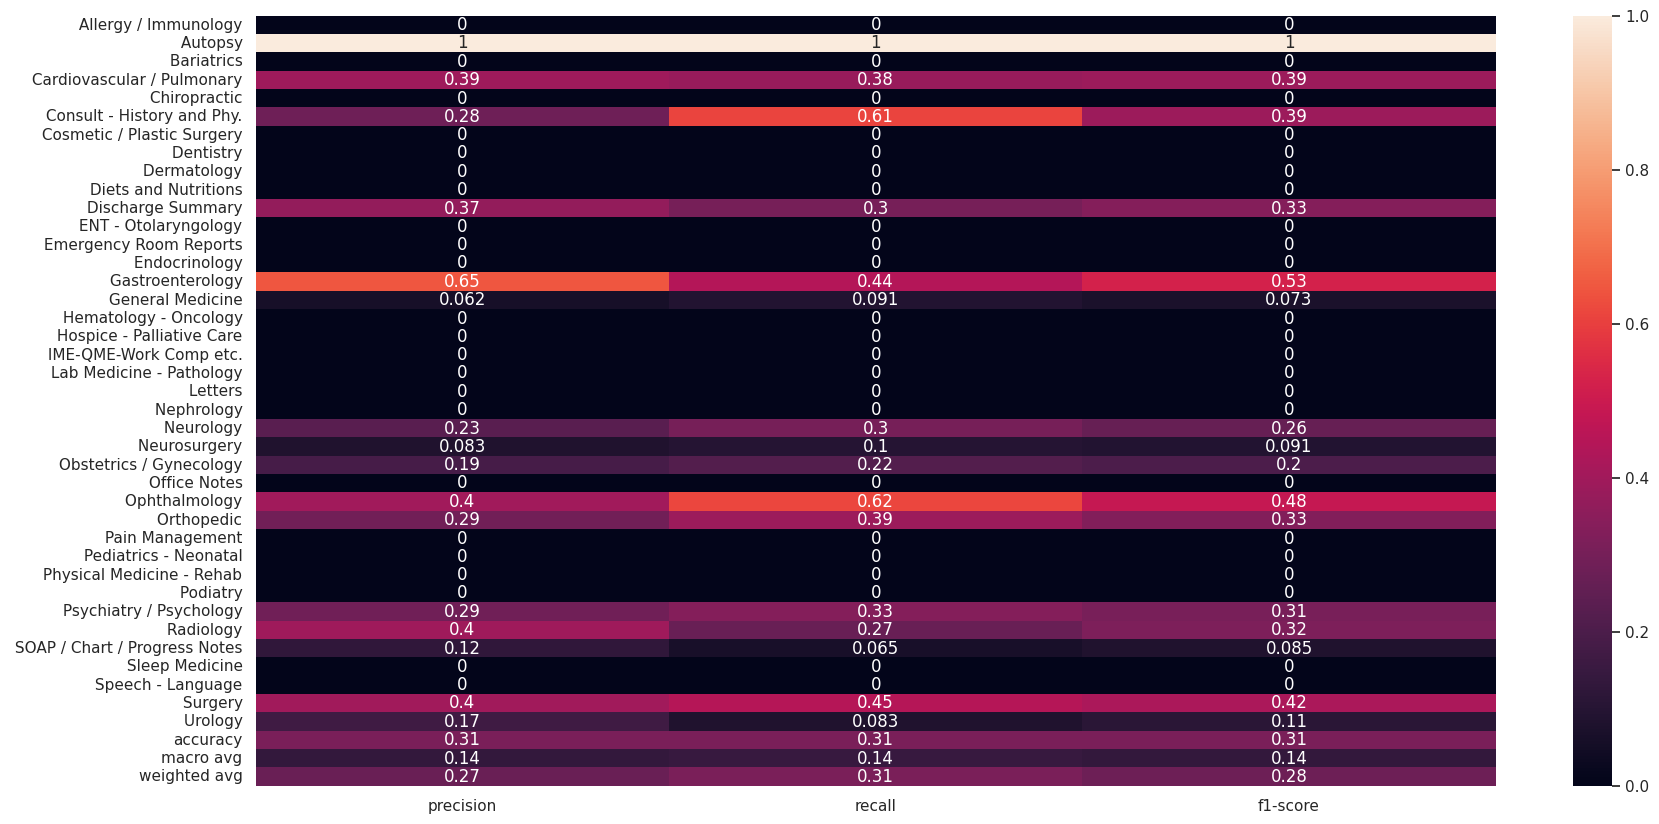

In [25]:
# 2. only with removing punctuation

print('Only with removing punctuation')

pipeline = Pipeline([
    ('data_cleaner', DataCleaner())
])

df = apply_preprocessing(pipeline=pipeline)
train(df, 'mlp', savename='only_removing_punctuation_mlp')

Only with removing punctuation
Lowercasing


100%|██████████| 4966/4966 [00:00<00:00, 234594.18it/s]


Removing punctuation


100%|██████████| 4966/4966 [00:00<00:00, 12486.71it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-define

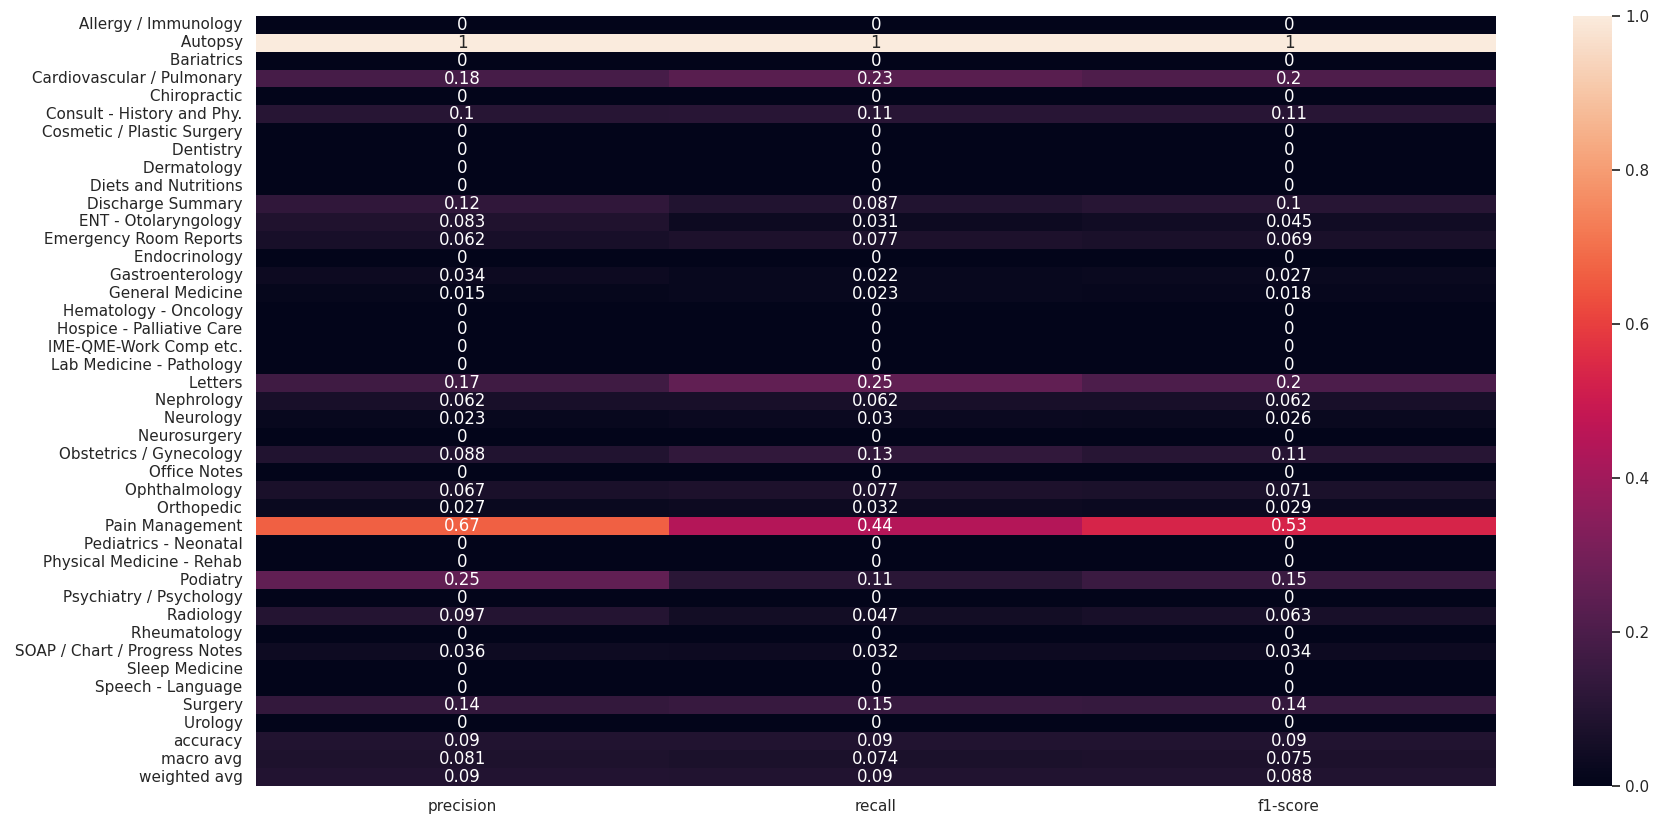

In [12]:
# 2. only with removing punctuation

print('Only with removing punctuation')

pipeline = Pipeline([
    ('data_cleaner', DataCleaner())
])

df = apply_preprocessing(pipeline=pipeline)
train(df, 'SVC', savename='only_removing_punctuation_svc')

Only with removing punctuation
Lowercasing


100%|██████████| 4966/4966 [00:00<00:00, 192669.43it/s]


Removing punctuation


100%|██████████| 4966/4966 [00:00<00:00, 11999.27it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are il

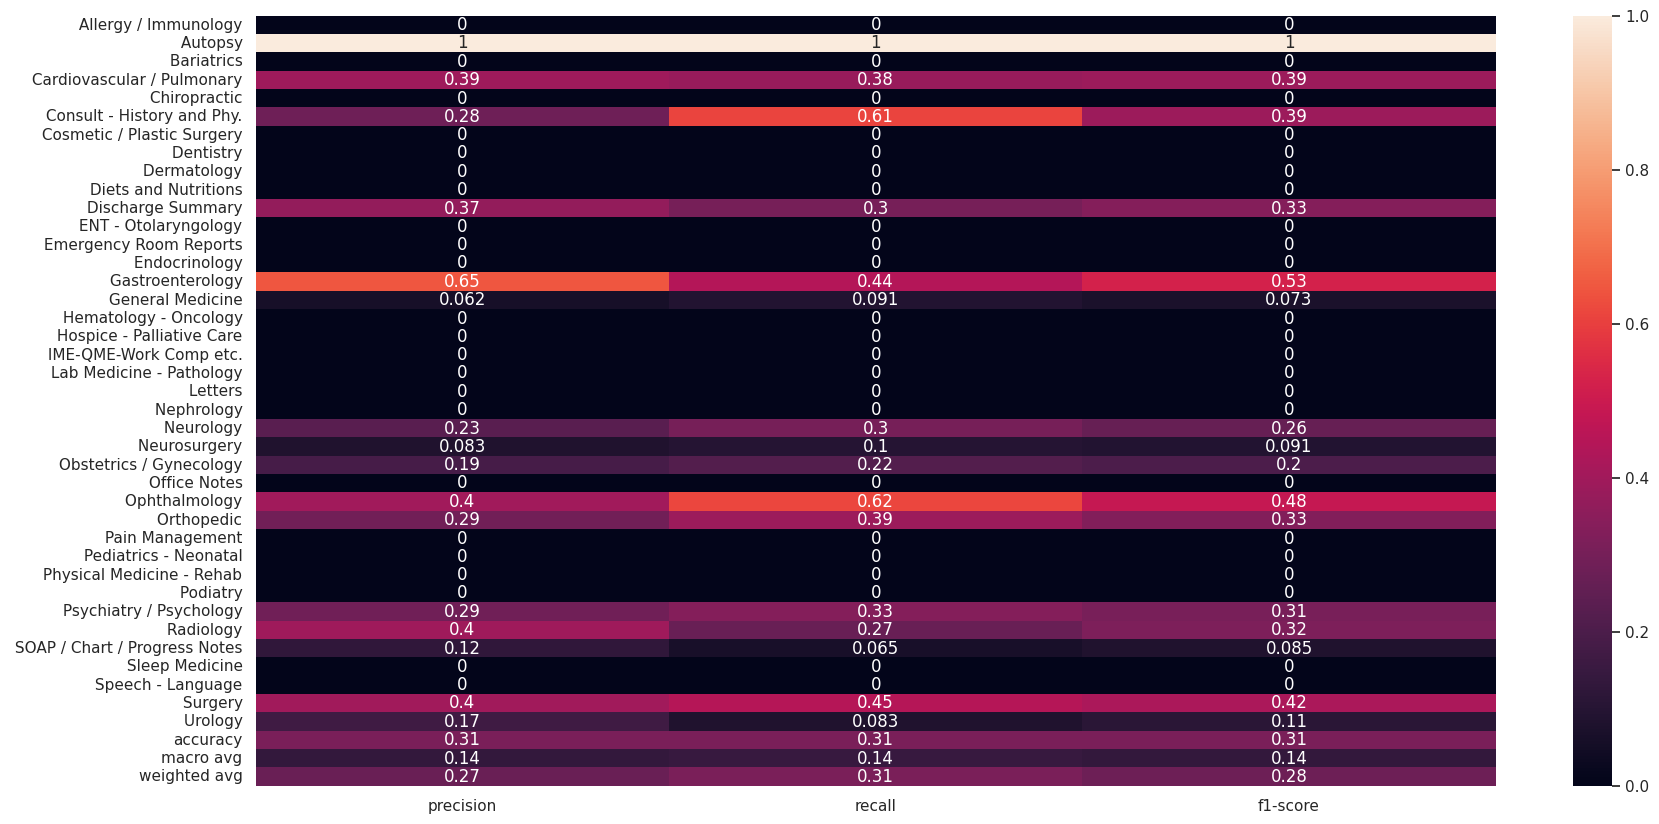

In [13]:
# 2. only with removing punctuation

print('Only with removing punctuation')

pipeline = Pipeline([
    ('data_cleaner', DataCleaner())
])

df = apply_preprocessing(pipeline=pipeline)
train(df, savename='only_removing_punctuation_bayes')

With removing punctuation and stop words
Lowercasing


100%|██████████| 4966/4966 [00:00<00:00, 228327.13it/s]


Removing punctuation


100%|██████████| 4966/4966 [00:00<00:00, 12794.74it/s]


Removing stop words


100%|██████████| 4966/4966 [00:05<00:00, 841.36it/s] 
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


using naive_bayes as default network architecture


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


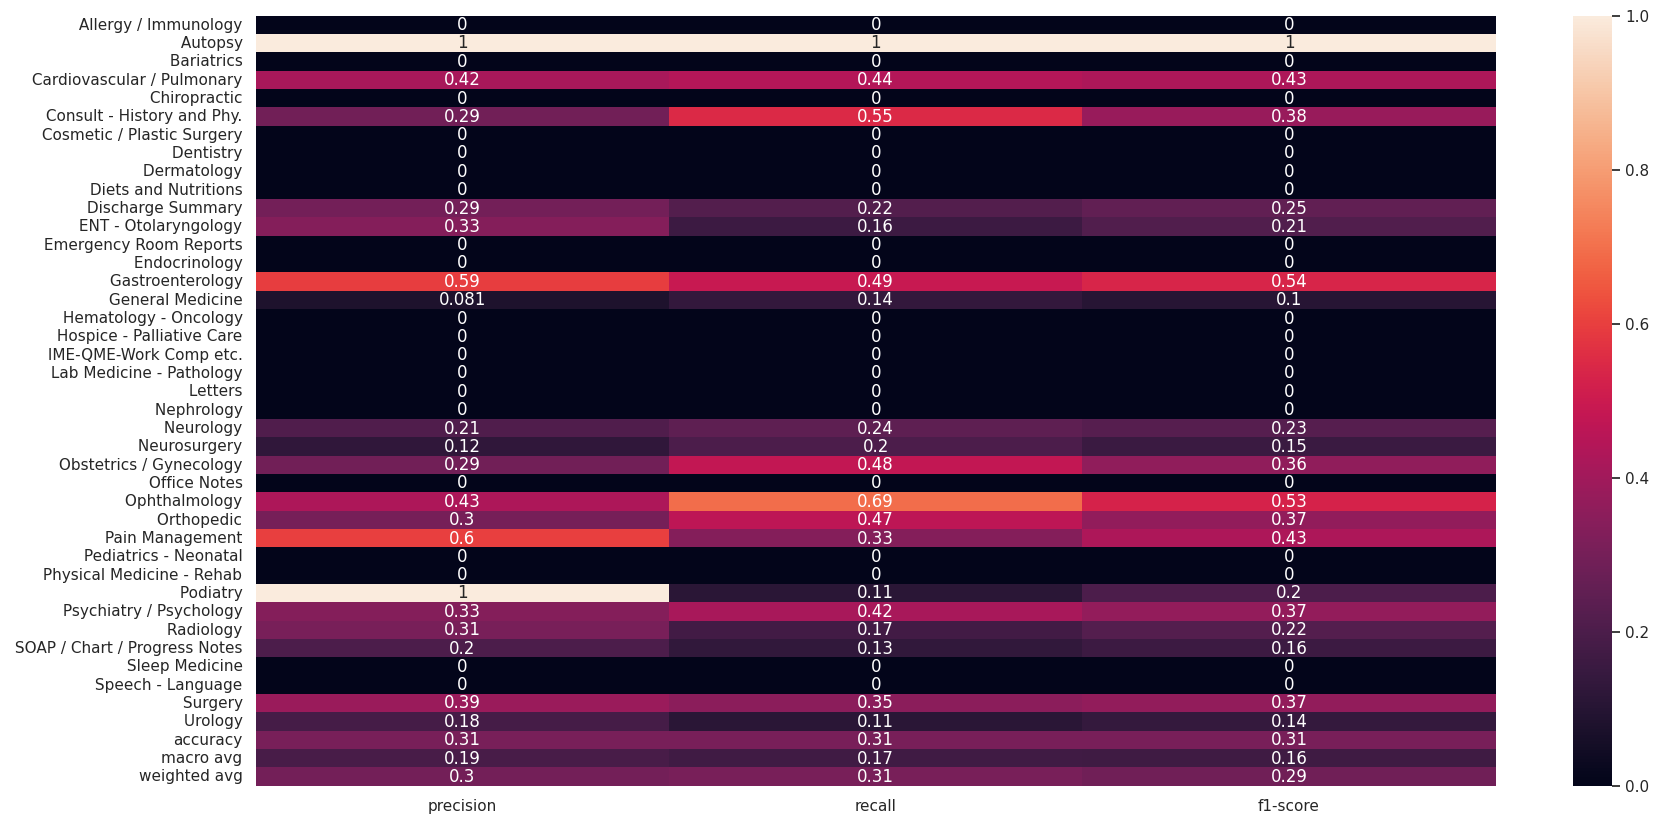

In [26]:
# 3. with removing punctuation and stop words

print('With removing punctuation and stop words')

pipeline = Pipeline([
    ('data_cleaner', DataCleaner()),
    ('stop_word_remover', StopWordRemover())
])

df = apply_preprocessing(pipeline=pipeline)
train(df, 'mlp', savename='removing_punctuation_and_stop_words_mlp')

With removing punctuation and stop words
Lowercasing


100%|██████████| 4966/4966 [00:00<00:00, 235418.80it/s]


Removing punctuation


100%|██████████| 4966/4966 [00:00<00:00, 12276.27it/s]


Removing stop words


100%|██████████| 4966/4966 [00:04<00:00, 1132.50it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined

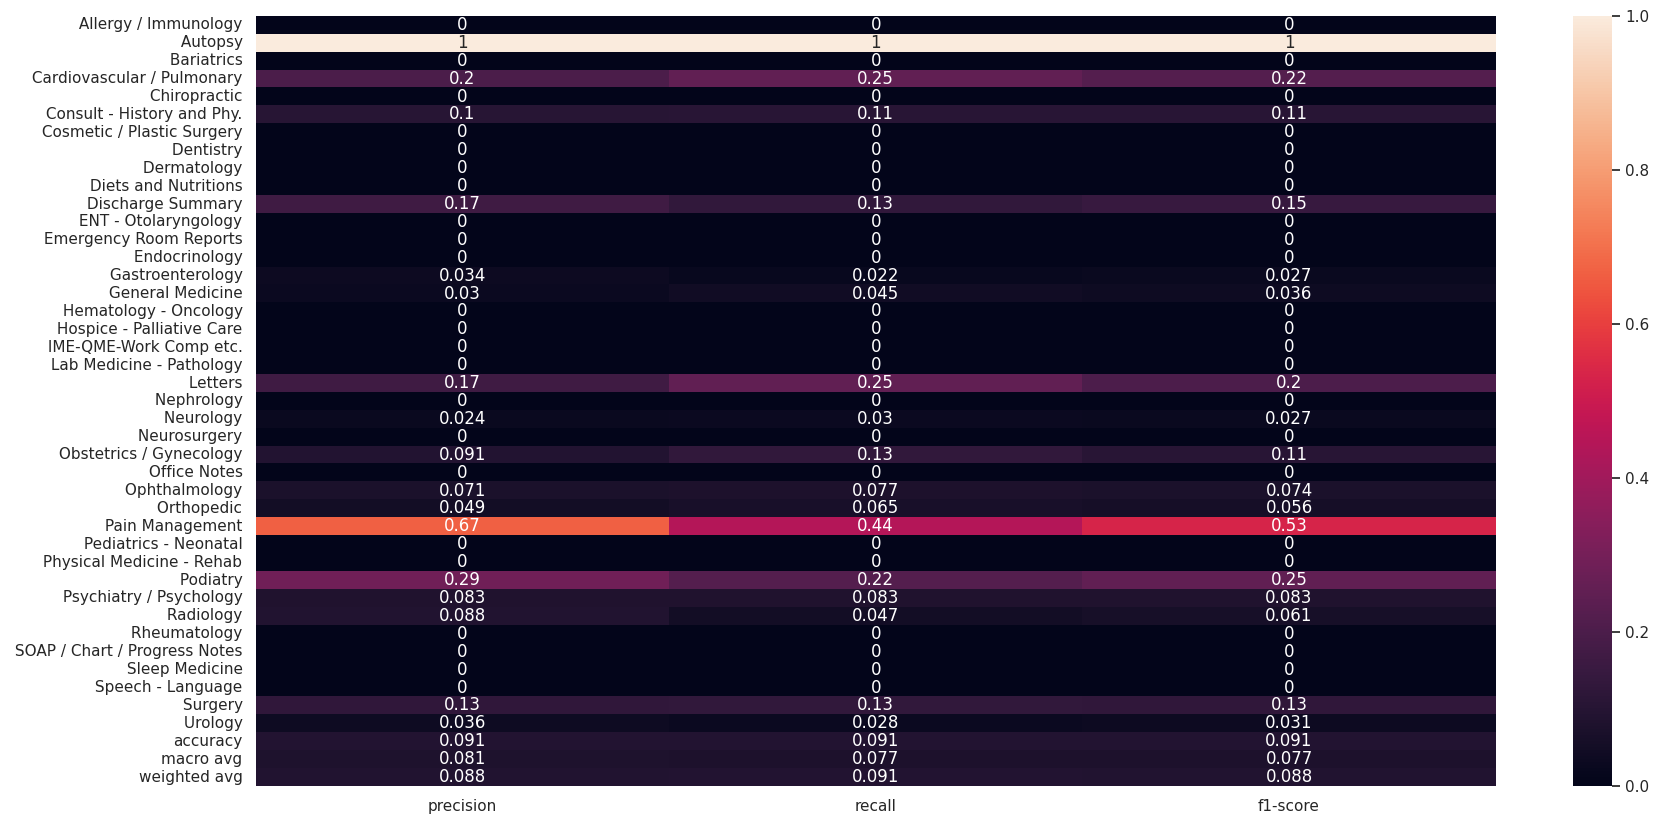

In [14]:
# 3. with removing punctuation and stop words

print('With removing punctuation and stop words')

pipeline = Pipeline([
    ('data_cleaner', DataCleaner()),
    ('stop_word_remover', StopWordRemover())
])

df = apply_preprocessing(pipeline=pipeline)
train(df, 'SVC', savename='removing_punctuation_and_stop_words_svc')

With removing punctuation and stop words
Lowercasing


100%|██████████| 4966/4966 [00:00<00:00, 231042.17it/s]


Removing punctuation


100%|██████████| 4966/4966 [00:00<00:00, 12262.03it/s]


Removing stop words


100%|██████████| 4966/4966 [00:04<00:00, 1134.62it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill

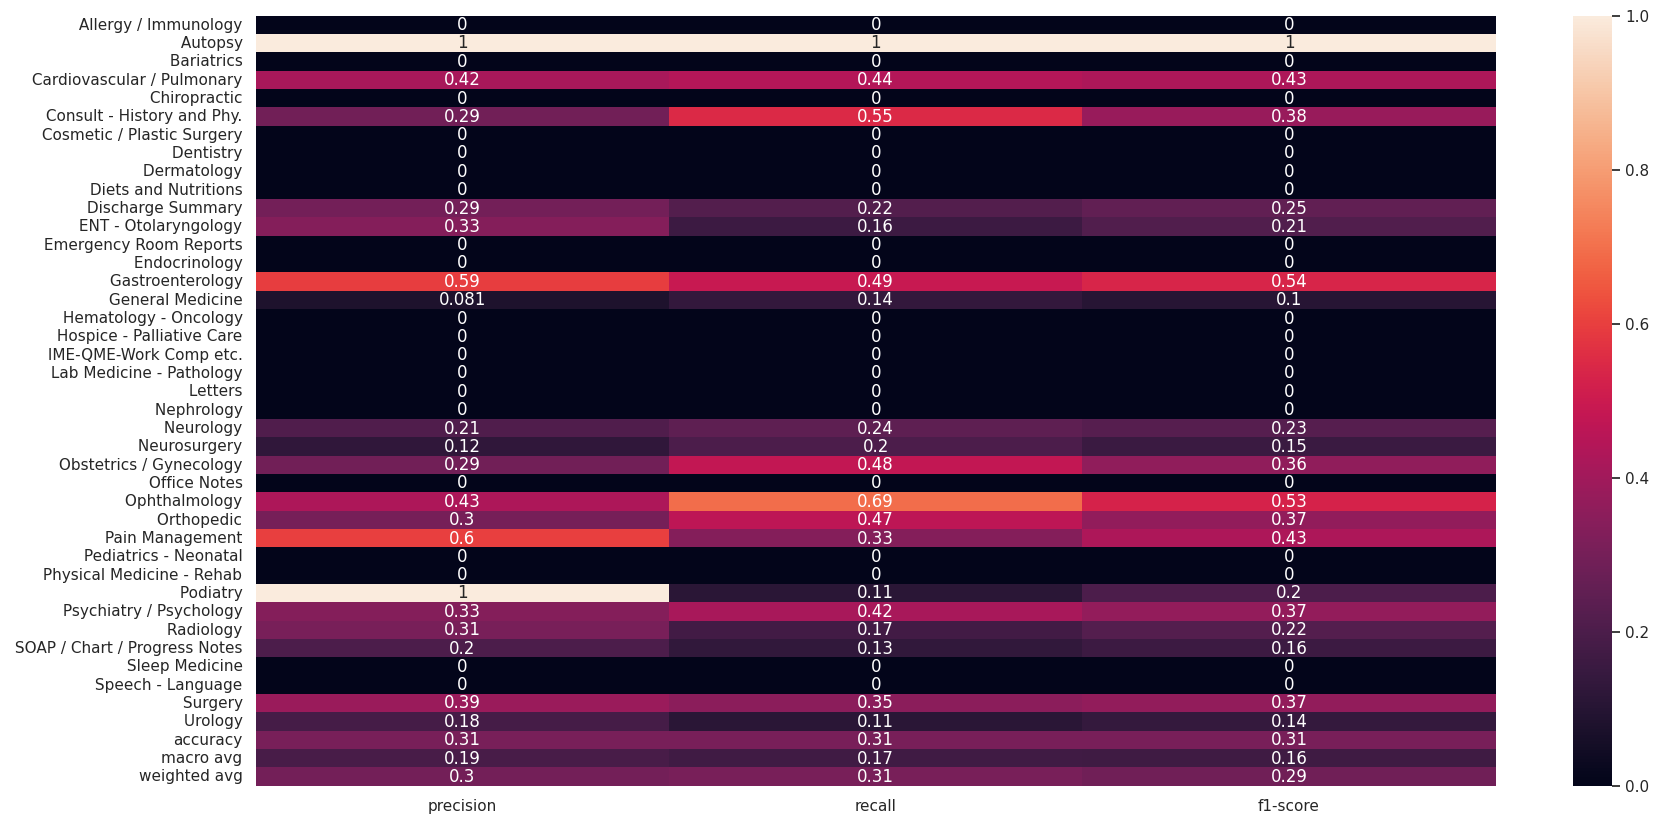

In [15]:
# 3. with removing punctuation and stop words

print('With removing punctuation and stop words')

pipeline = Pipeline([
    ('data_cleaner', DataCleaner()),
    ('stop_word_remover', StopWordRemover())
])

df = apply_preprocessing(pipeline=pipeline)
train(df, savename='removing_punctuation_and_stop_words_bayes')

With removing punctuation, stop words and stemming
Lowercasing


100%|██████████| 4966/4966 [00:00<00:00, 218243.21it/s]


Removing punctuation


100%|██████████| 4966/4966 [00:00<00:00, 12897.53it/s]


Removing stop words


100%|██████████| 4966/4966 [00:04<00:00, 1131.48it/s]


Stemming


100%|██████████| 4966/4966 [00:36<00:00, 136.16it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


using naive_bayes as default network architecture


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


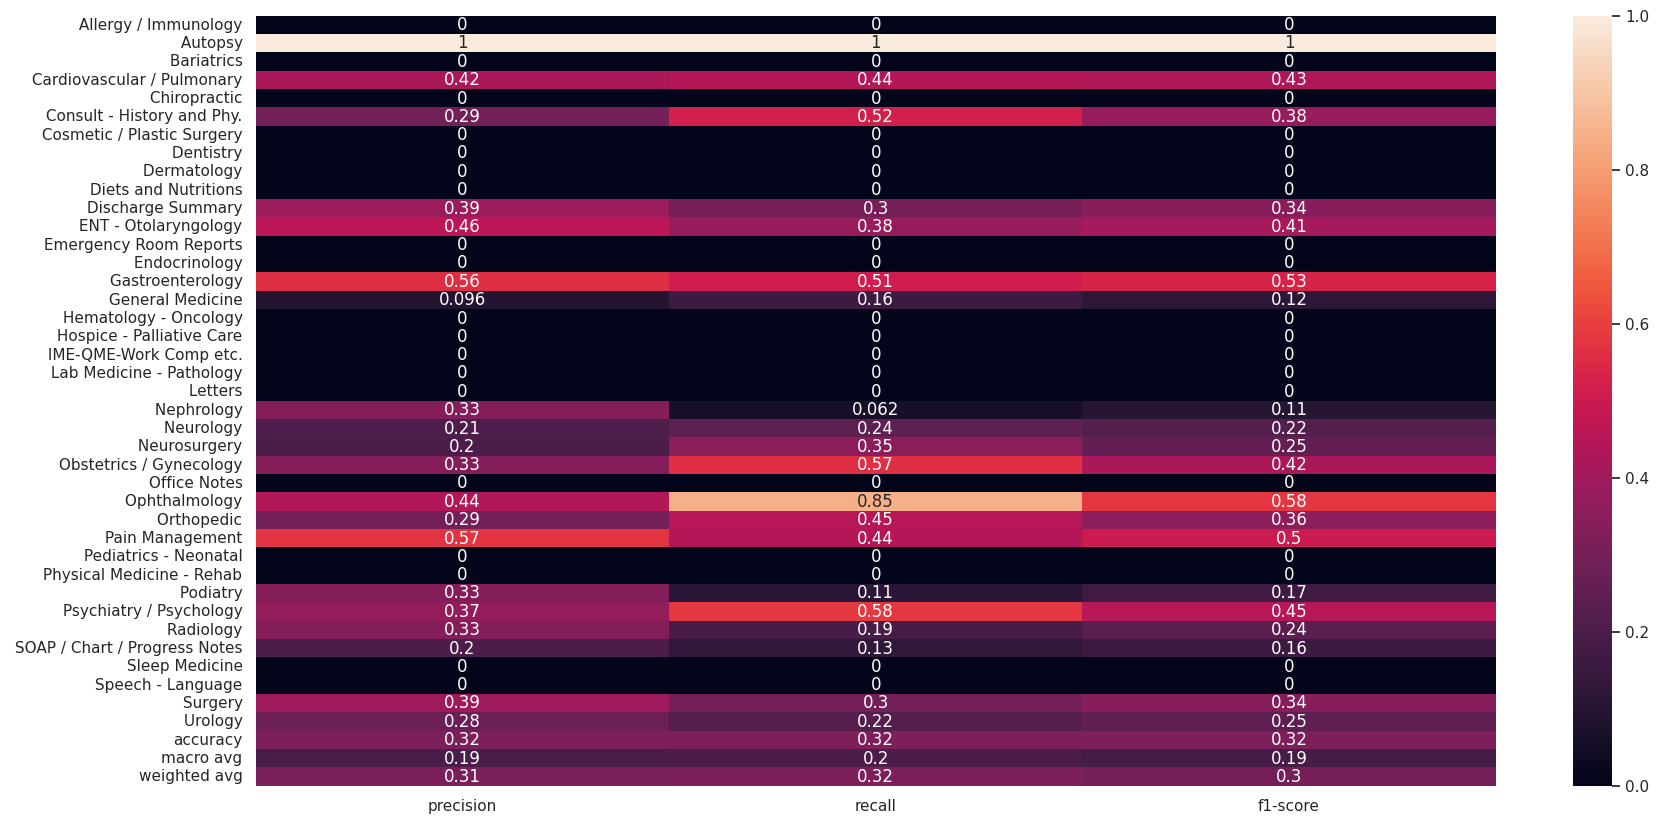

In [27]:
# 4. with removing punctuation, stop words and stemming

print('With removing punctuation, stop words and stemming')

pipeline = Pipeline([
    ('data_cleaner', DataCleaner()),
    ('stop_word_remover', StopWordRemover()),
    ('stemmer', Stemmer())
])

df = apply_preprocessing(pipeline=pipeline)
train(df, 'mlp', savename='removing_punctuation_stop_words_and_stemming_mlp')

With removing punctuation, stop words and stemming
Lowercasing


100%|██████████| 4966/4966 [00:00<00:00, 240807.83it/s]


Removing punctuation


100%|██████████| 4966/4966 [00:00<00:00, 12726.86it/s]


Removing stop words


100%|██████████| 4966/4966 [00:05<00:00, 852.13it/s] 


Stemming


100%|██████████| 4966/4966 [00:31<00:00, 156.68it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined 

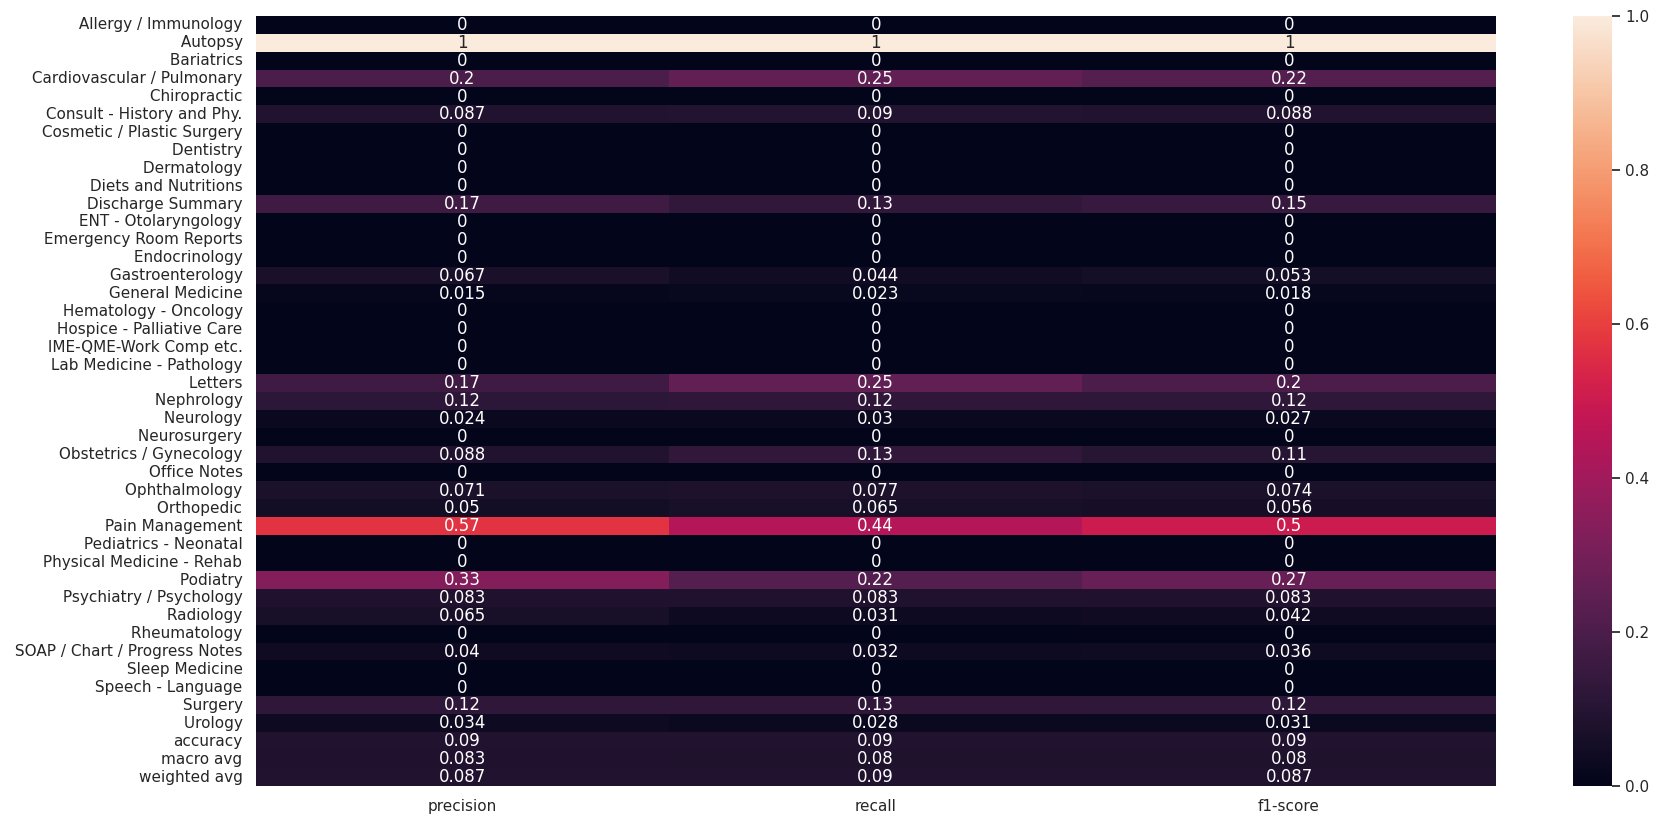

In [16]:
# 4. with removing punctuation, stop words and stemming

print('With removing punctuation, stop words and stemming')

pipeline = Pipeline([
    ('data_cleaner', DataCleaner()),
    ('stop_word_remover', StopWordRemover()),
    ('stemmer', Stemmer())
])

df = apply_preprocessing(pipeline=pipeline)
train(df, 'SVC', savename='removing_punctuation_stop_words_and_stemming_svc')

With removing punctuation, stop words and stemming
Lowercasing


100%|██████████| 4966/4966 [00:00<00:00, 200037.59it/s]


Removing punctuation


100%|██████████| 4966/4966 [00:00<00:00, 12706.54it/s]


Removing stop words


100%|██████████| 4966/4966 [00:05<00:00, 850.29it/s]


Stemming


100%|██████████| 4966/4966 [00:31<00:00, 156.50it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-

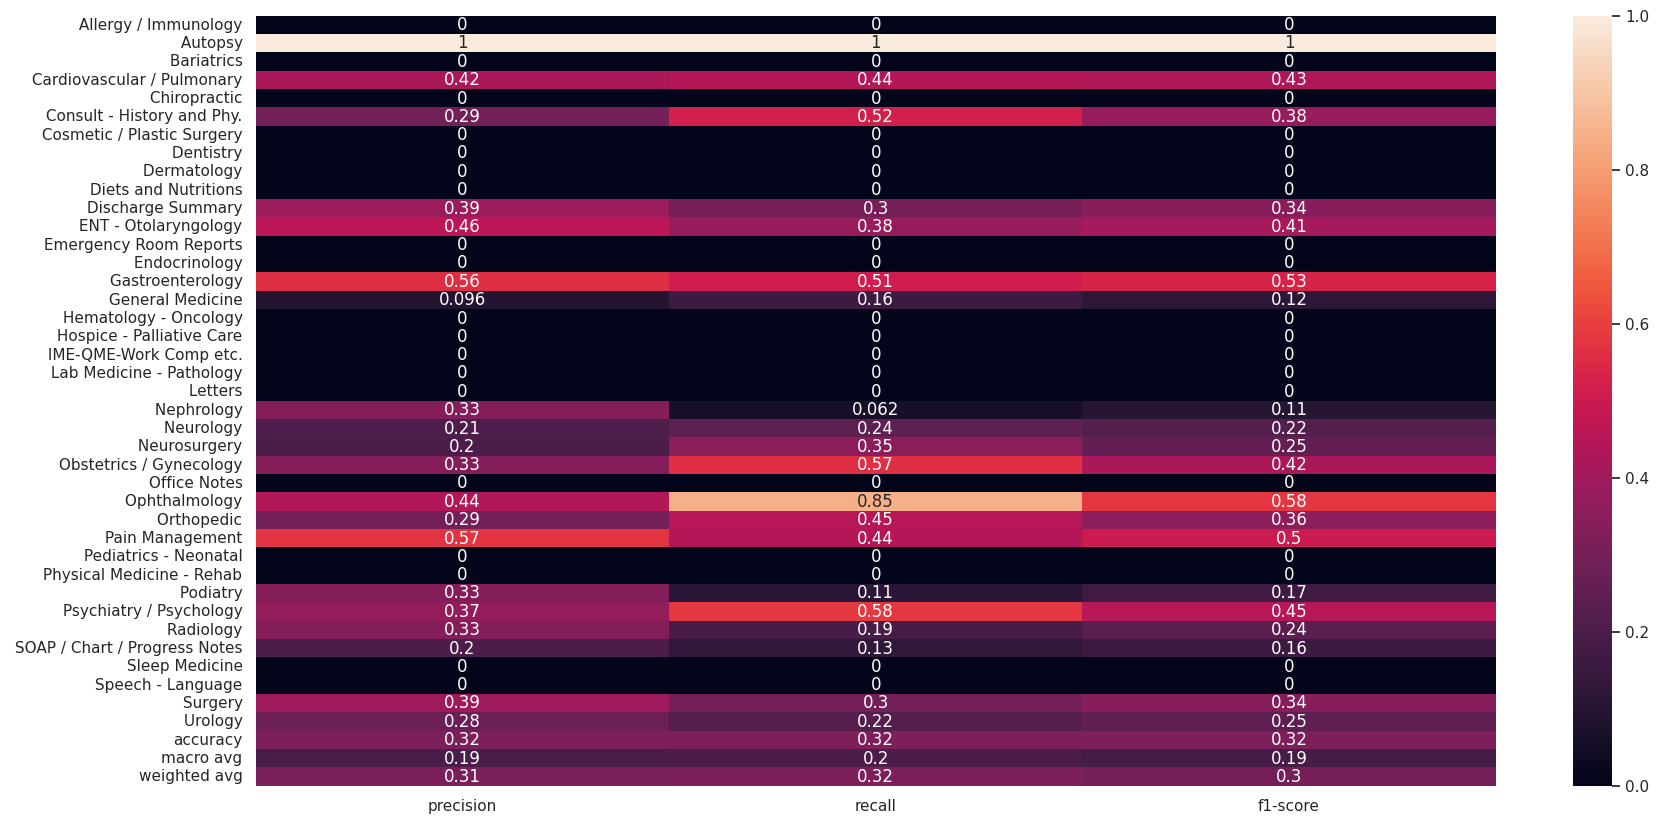

In [17]:
# 4. with removing punctuation, stop words and stemming

print('With removing punctuation, stop words and stemming')

pipeline = Pipeline([
    ('data_cleaner', DataCleaner()),
    ('stop_word_remover', StopWordRemover()),
    ('stemmer', Stemmer())
])

df = apply_preprocessing(pipeline=pipeline)
train(df, savename='removing_punctuation_stop_words_and_stemming_bayes')

With removing punctuation, stop words and lemmatizing
Lowercasing


100%|██████████| 4966/4966 [00:00<00:00, 447673.69it/s]


Removing punctuation


100%|██████████| 4966/4966 [00:00<00:00, 18937.65it/s]


Removing stop words


100%|██████████| 4966/4966 [00:03<00:00, 1444.01it/s]


Lemmatizing


100%|██████████| 4966/4966 [00:03<00:00, 1429.66it/s]
/Users/manuel/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


KNN


/Users/manuel/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/manuel/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/manuel/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


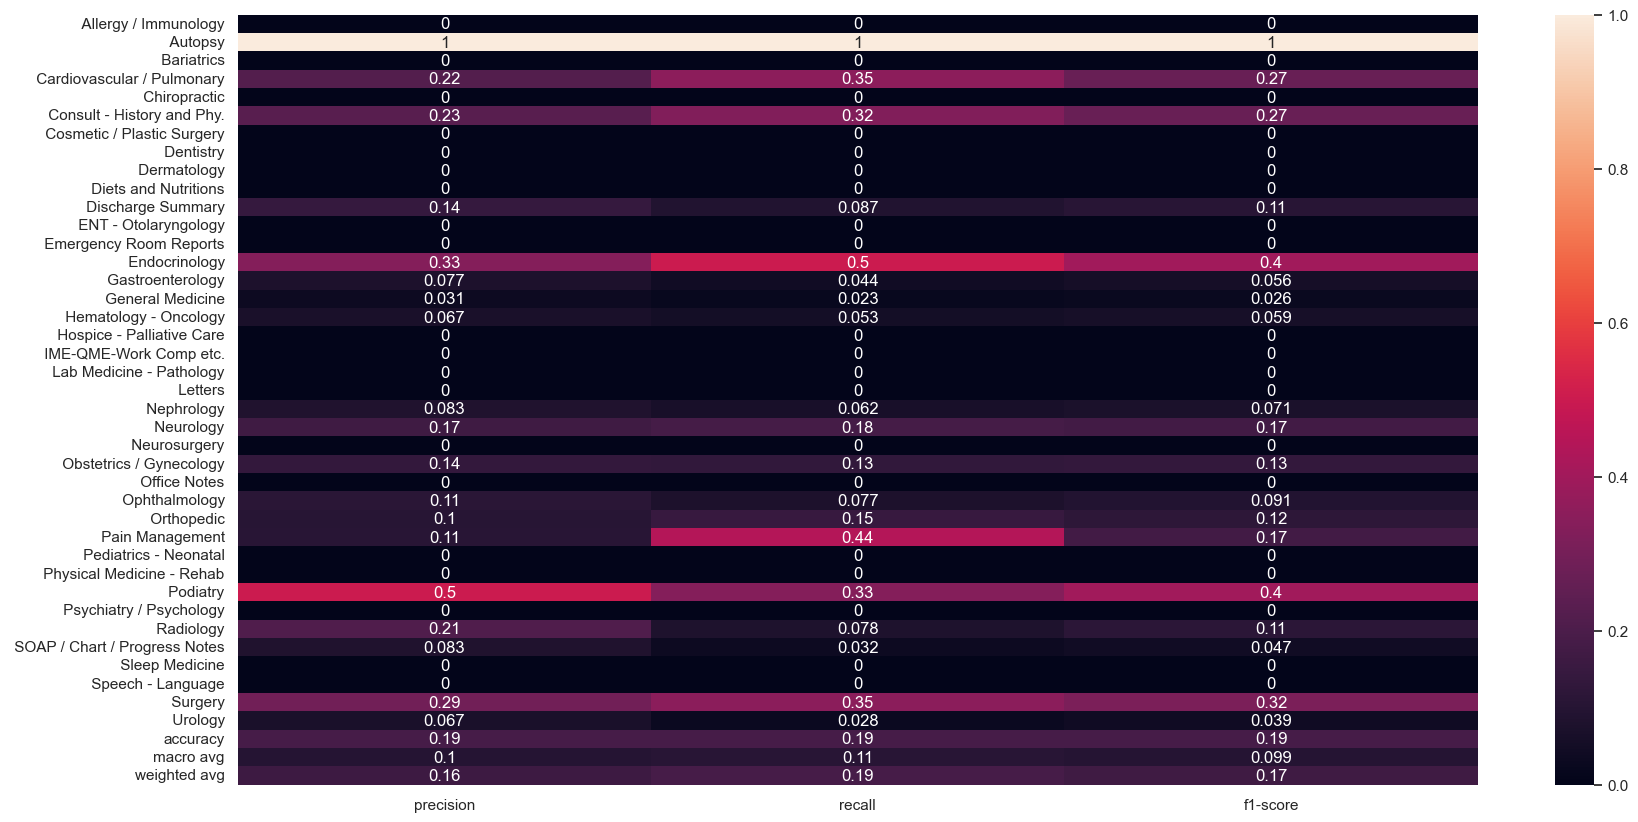

In [25]:
# 4. with removing punctuation, stop words and lemmatizing

print('With removing punctuation, stop words and lemmatizing')

pipeline = Pipeline([
    ('data_cleaner', DataCleaner()),
    ('stop_word_remover', StopWordRemover()),
    ('lemmatizer', Lemmatizer()),
])

df = apply_preprocessing(pipeline=pipeline)
train(df, 'knn', savename='removing_punctuation_stop_words_and_lemmatizing_knn')

In [ ]:
# 4. with removing punctuation, stop words and lemmatizing

print('With removing punctuation, stop words and lemmatizing')

pipeline = Pipeline([
    ('data_cleaner', DataCleaner()),
    ('stop_word_remover', StopWordRemover()),
    ('lemmatizer', Lemmatizer()),
])

df = apply_preprocessing(pipeline=pipeline)
train(df, 'mlp', savename='removing_punctuation_stop_words_and_lemmatizing_mlp')

With removing punctuation, stop words and lemmatizing
Lowercasing


100%|██████████| 4966/4966 [00:00<00:00, 142994.84it/s]


Removing punctuation


100%|██████████| 4966/4966 [00:00<00:00, 10743.84it/s]


Removing stop words


100%|██████████| 4966/4966 [00:04<00:00, 1129.85it/s]


Lemmatizing


100%|██████████| 4966/4966 [00:06<00:00, 815.03it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


MLP


With removing punctuation, stop words and lemmatizing
Lowercasing


100%|██████████| 4966/4966 [00:00<00:00, 197036.39it/s]


Removing punctuation


100%|██████████| 4966/4966 [00:00<00:00, 12814.99it/s]


Removing stop words


100%|██████████| 4966/4966 [00:05<00:00, 846.23it/s] 


Lemmatizing


100%|██████████| 4966/4966 [00:07<00:00, 677.61it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined 

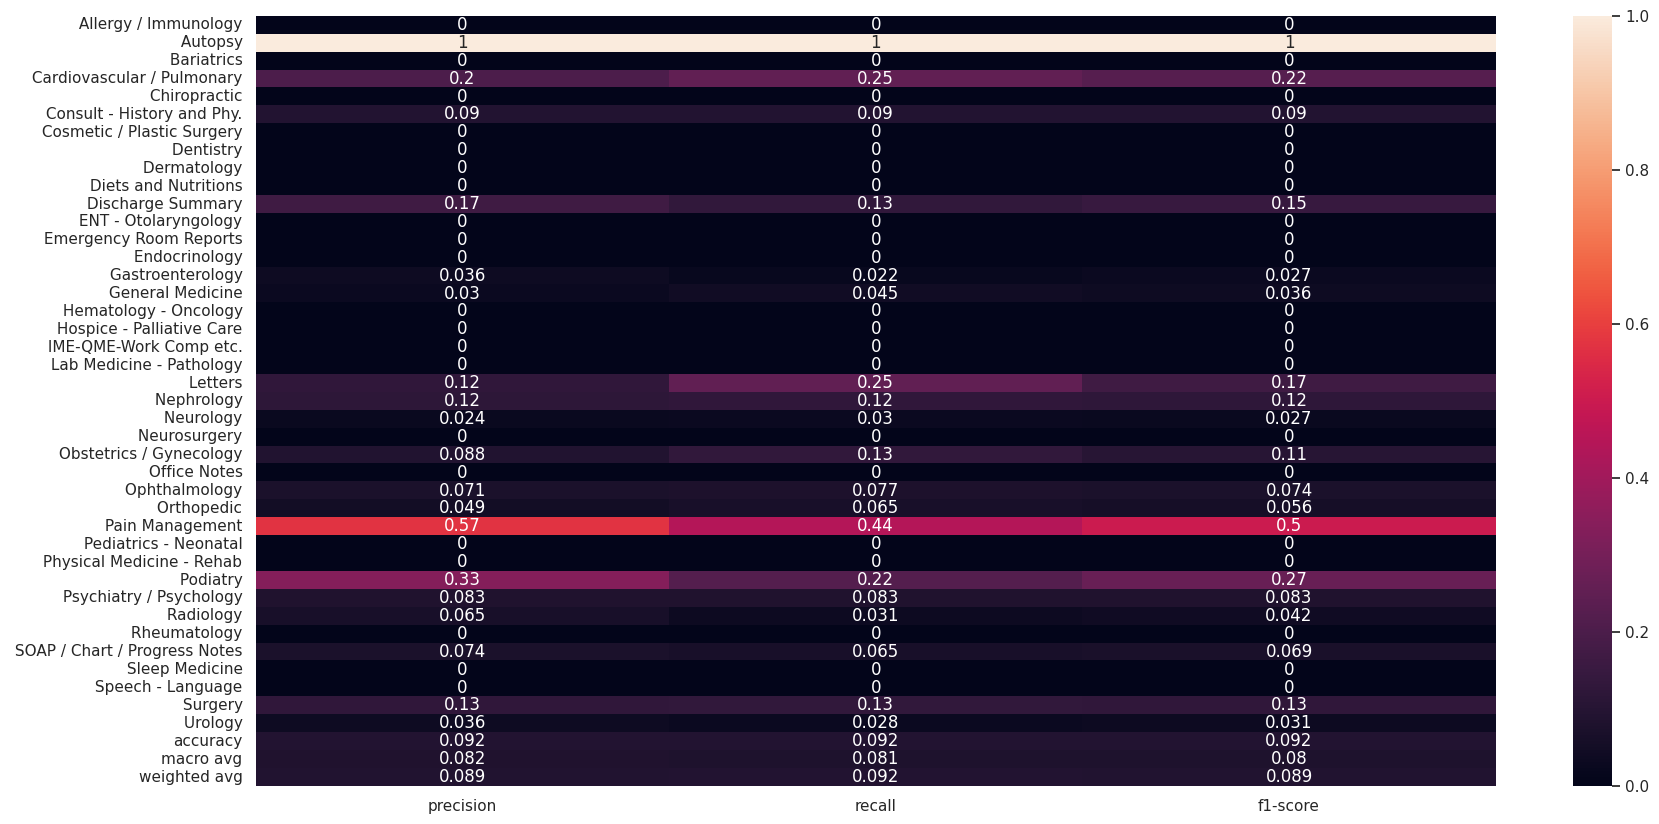

In [18]:
# 4. with removing punctuation, stop words and lemmatizing

print('With removing punctuation, stop words and lemmatizing')

pipeline = Pipeline([
    ('data_cleaner', DataCleaner()),
    ('stop_word_remover', StopWordRemover()),
    ('lemmatizer', Lemmatizer()),
])

df = apply_preprocessing(pipeline=pipeline)
train(df, 'SVC', savename='removing_punctuation_stop_words_and_lemmatizing_svc')

With removing punctuation, stop words and lemmatizing
Lowercasing


100%|██████████| 4966/4966 [00:00<00:00, 107037.25it/s]


Removing punctuation


100%|██████████| 4966/4966 [00:00<00:00, 8919.65it/s]


Removing stop words


100%|██████████| 4966/4966 [00:04<00:00, 1135.02it/s]


Lemmatizing


100%|██████████| 4966/4966 [00:05<00:00, 832.28it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-

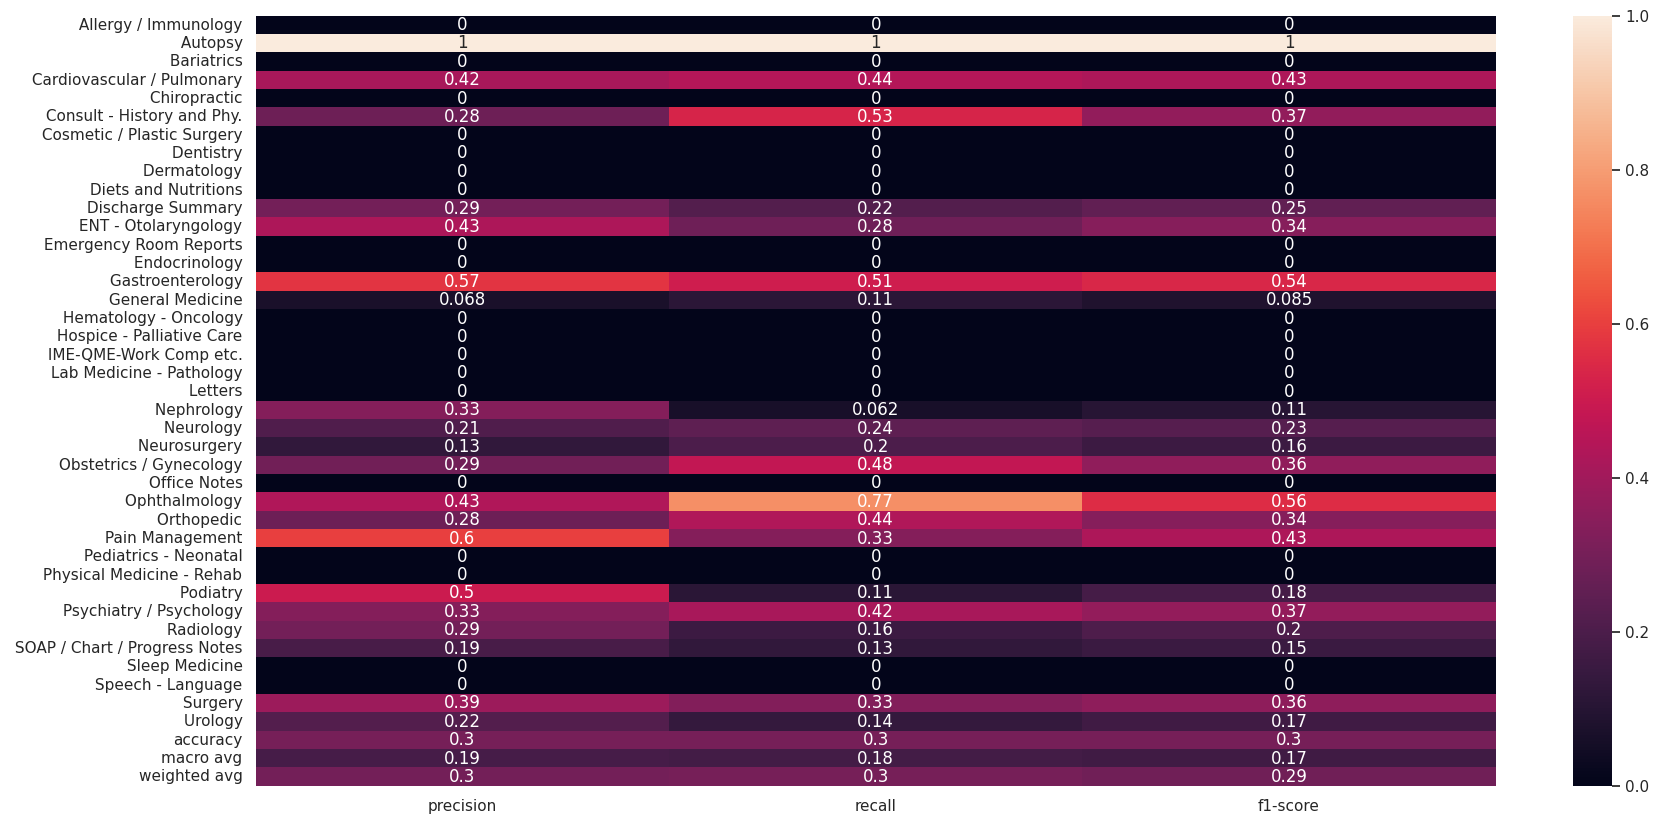

In [19]:
# 4. with removing punctuation, stop words and lemmatizing

print('With removing punctuation, stop words and lemmatizing')

pipeline = Pipeline([
    ('data_cleaner', DataCleaner()),
    ('stop_word_remover', StopWordRemover()),
    ('lemmatizer', Lemmatizer()),
])

df = apply_preprocessing(pipeline=pipeline)
train(df, savename='removing_punctuation_stop_words_and_lemmatizing_bayes')

In order to train and test the machine learnign model on your preprocessed dataset, the dataframe should have the same column names as in the original dataset.

In [23]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer

df = pd.read_csv('MIR/Data/mtsamples_clean.csv')

counter = Counter(df['medical_specialty'].tolist())
top_10_varieties = {i[0]: idx for idx, i in enumerate(counter.most_common(10))}
df = df[df['medical_specialty'].map(lambda x: x in top_10_varieties)]

description_list = df['transcription'].tolist()
varietal_list = [top_10_varieties[i] for i in df['medical_specialty'].tolist()]
varietal_list = np.array(varietal_list)

count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(description_list)


tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

train_x, test_x, train_y, test_y = train_test_split(x_train_tfidf, varietal_list, test_size=0.3)

clf = MultinomialNB().fit(train_x, train_y)
y_score = clf.predict(test_x)

n_right = 0
for i in range(len(y_score)):
    if y_score[i] == test_y[i]:
        n_right += 1

print("Accuracy: %.2f%%" % ((n_right/float(len(test_y)) * 100)))

ValueError: ignored